In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  

import tensorflow as tf
import os
import pandas as pd
import numpy as np
 
def call_data(URL): ## function to call data TXT FILE
    data = pd.read_csv(URL, names=['time', 'open', 'high', 'low', 'close', 'volume'], delimiter = ";", index_col='time')
    data = data.drop_duplicates()
    # change index to date time 
    data.index = pd.to_datetime(data.index)
    return data



In [2]:
# split data into train and test and validation
def split_data_LSTM(data,train_size = 0.7, val_size = 0.2):
    train = data[:int(len(data)* train_size)]
    val = data[int(len(data)*train_size): int(len(data)*(train_size+val_size))]
    test = data[int(len(data)*(train_size+val_size)):]
    return train, val, test


def scale_data(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, WINDOW_SIZE):
    xs = []
    ys = []
    for i in range(len(data)-WINDOW_SIZE-1):
        x = data[i:(i+WINDOW_SIZE)]
        y = data[i+WINDOW_SIZE]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def build_LSTM(WINDOW_SIZE = 5):
    model = Sequential()
    model.add(LSTM(units=6, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=12, return_sequences=True))
    model.add(LSTM(units=24, return_sequences=True))
    model.add(Dense(1))
    model.summary()
    return model

def plot_loss(model):
    # plot loss
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='validation')
    plt.title('Loss score')
    plt.legend()
    plt.show()

            
    


In [3]:
##### Prepare LSTM Parameters ########
WINDOW_SIZE = 5 # its the look back window size

##### get github txt file data ######
url = 'https://raw.githubusercontent.com/Jpaku93/ML_Stock_Regression/main/MES%2006-21.Last.txt' # URL string to call data
data = call_data(url)[:2000] # call data with url string
# data.head()
col_names = list(data)[1:len(data.columns)] # list of columns
training_data = data[col_names].astype(float) # training data

In [4]:
# import standard scaler to scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(training_data.values.reshape(-1, len(col_names)))

trainX = []
trainY = []

##################################################################
########################### Parameters ###########################
##################################################################

batch_size = 32 # Number of samples per gradient update
n_future = 1   # Number of days we want to predict into the future
n_past = 14 # Number of past days we want to use to predict the future

for i in range(n_past, len(scaled_data) - n_future +1):
    trainX.append(scaled_data[i - n_past:i, 0:scaled_data.shape[1]])
    trainY.append(scaled_data[i + n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print(trainX.shape)
print(trainY.shape)

(1986, 14, 4)
(1986, 1)


In [9]:
import tensorflow as tf



# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=batch_size, validation_split=0.1, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 14, 64)            17664     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50,753
Trainable params: 50,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
56/56 [==============================] - 5s 23ms/step - loss: 0.0994 - val_loss: 0.1018
Epoch 2/20
56/56 [==============================] - 1s 14ms/step - loss: 0.0300 - v

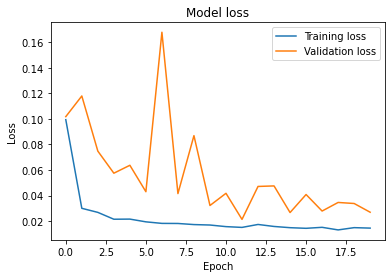

In [10]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [15]:
n_future = 20   # Number of days we want to predict into the future
forecast_period_dates = pd.date_range(list(data.index)[-1], periods=n_future, freq='min').tolist()
forecast = model.predict(trainX[-n_future:]) #forecast


1/1 [==============================] - 0s 36ms/step


In [33]:
original['time']

0      2021-03-22 11:01:00
1      2021-03-22 11:02:00
2      2021-03-22 11:03:00
3      2021-03-22 11:04:00
4      2021-03-22 11:05:00
               ...        
1995   2021-03-23 22:49:00
1996   2021-03-23 22:50:00
1997   2021-03-23 22:51:00
1998   2021-03-23 22:52:00
1999   2021-03-23 22:53:00
Name: time, Length: 2000, dtype: datetime64[ns]

c:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='open'>

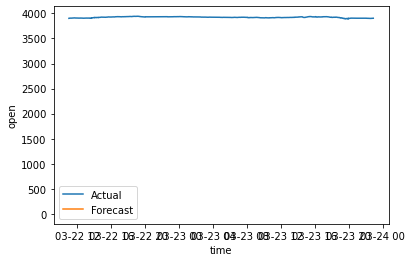

In [37]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

# Create dataframe
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':np.array(forecast[:,0])})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

original = data.reset_index()[['time', 'open']]
original['time'] = pd.to_datetime(original['time'])

import seaborn as sns
sns.lineplot(original['time'], original['open'], label='Actual')
sns.lineplot(df_forecast['Date'], df_forecast['Close'], label='Forecast')
            


In [30]:
# Plot the forecast
plt.figure(figsize=(20, 6))
plt.plot(original['Date'], original['Close'])
plt.plot(df_forecast['Date'], df_forecast['Close'])
plt.title('Forecast vs Actuals')
plt.legend(['Actuals', 'Forecast'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()
    

KeyError: 'Date'

<Figure size 1440x432 with 0 Axes>

In [18]:
# Make predictions
trainPredict = model.predict(trainX)
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
# Calculate root mean squared error
trainScore = np.sqrt(mse(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

        

63/63 [==============================] - 0s 6ms/step


ValueError: non-broadcastable output operand with shape (1986,1) doesn't match the broadcast shape (1986,4)

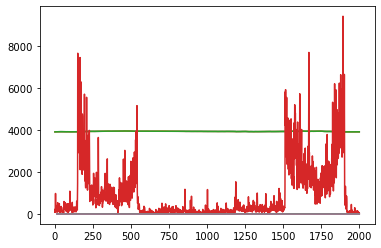

In [8]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_past:len(trainPredict)+n_past, :] = trainPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.show()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 6)              192       
                                                                 
 lstm_4 (LSTM)               (None, 5, 12)             912       
                                                                 
 lstm_5 (LSTM)               (None, 5, 24)             3552      
                                                                 
 dense (Dense)               (None, 5, 1)              25        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
175/175 [==============================] - 8s 14ms/step - loss: 0.0439 - root_mean_squared_error: 0.2094 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 2/10

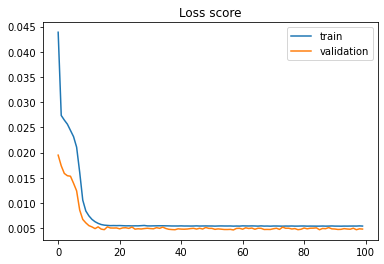

In [ ]:
# scale data for LSTM
scaled_data, scaler = scale_data(training_data)
# split data into train, val, test
train, val, test = split_data_LSTM(scaled_data, train_size = 0.7, val_size = 0.2)
# create sequences
X_train, y_train = create_sequences(train, WINDOW_SIZE)
X_val, y_val = create_sequences(val, WINDOW_SIZE)
X_test, y_test = create_sequences(test, WINDOW_SIZE)

# reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# build LSTM model
model = build_LSTM(WINDOW_SIZE)
# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])
# fit model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
# plot loss
plot_loss(model)



In [ ]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['close'])])

fig.show()


In [ ]:


    
##### Prepare LSTM ########
model = build_LSTM(WINDOW_SIZE) # RETURN: model
cp = ModelCheckpoint('LSTM/', save_best_only=True) # save model
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) # compile model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 6)              192       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 12)             912       
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 24)             3552      
_________________________________________________________________
dense (Dense)                (None, 5, 1)              25        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##### Train LSTM ########
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs= 10, callbacks=[cp]) # fit model TRAINING

Epoch 1/10
44/44 [==============================] - 10s 34ms/step - loss: 0.3370 - root_mean_squared_error: 0.5805 - val_loss: 0.2995 - val_root_mean_squared_error: 0.5473


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 2/10
44/44 [==============================] - 1s 17ms/step - loss: 0.3102 - root_mean_squared_error: 0.5570 - val_loss: 0.2744 - val_root_mean_squared_error: 0.5238


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 3/10
44/44 [==============================] - 1s 14ms/step - loss: 0.2816 - root_mean_squared_error: 0.5307 - val_loss: 0.2470 - val_root_mean_squared_error: 0.4970


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 4/10
44/44 [==============================] - 1s 15ms/step - loss: 0.2496 - root_mean_squared_error: 0.4996 - val_loss: 0.2159 - val_root_mean_squared_error: 0.4647


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 5/10
44/44 [==============================] - 1s 15ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618 - val_loss: 0.1819 - val_root_mean_squared_error: 0.4265


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 6/10
44/44 [==============================] - 1s 16ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 0.1490 - val_root_mean_squared_error: 0.3861


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 7/10
44/44 [==============================] - 1s 16ms/step - loss: 0.1417 - root_mean_squared_error: 0.3764 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 8/10
44/44 [==============================] - 1s 12ms/step - loss: 0.1231 - root_mean_squared_error: 0.3509 - val_loss: 0.1189 - val_root_mean_squared_error: 0.3448


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 9/10
44/44 [==============================] - 1s 19ms/step - loss: 0.1168 - root_mean_squared_error: 0.3418 - val_loss: 0.1163 - val_root_mean_squared_error: 0.3410


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 10/10
44/44 [==============================] - 1s 12ms/step - loss: 0.1137 - root_mean_squared_error: 0.3371 - val_loss: 0.1138 - val_root_mean_squared_error: 0.3373


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


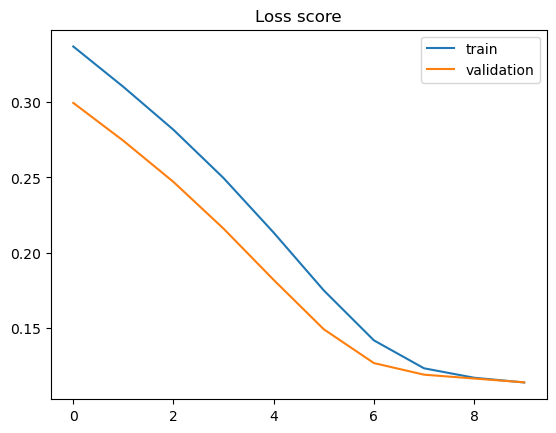

In [ ]:
##### evaluate loss LSTM ########
plot_loss(model) # plot loss

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('LSTM/')

In [ ]:
y_pred = model.predict(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)).flatten()
y_pred = train_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = train_scaler.inverse_transform(y_train_scaled)

NameError: name 'X_train_scaled' is not defined

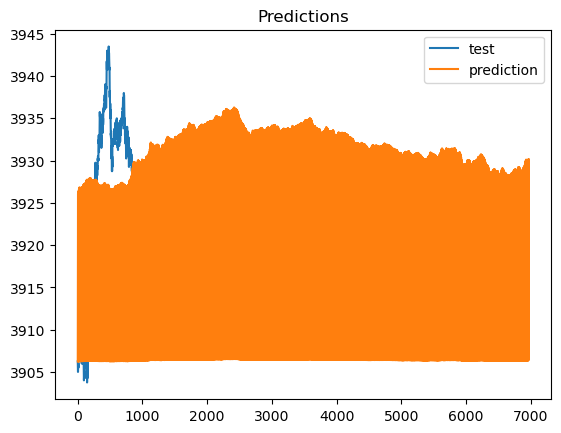

In [ ]:
# plot predictions
plt.plot(y_test, label='test')
plt.plot(y_pred, label='prediction')
plt.title('Predictions')
plt.legend()
plt.show()


In [ ]:
X_train_scaled.shape

(1394, 5, 1)

In [ ]:
y_train_scaled.shape

(1394, 1)

In [ ]:
# plot training evaluation
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

df, mse = plot_predictions1(model, X_train_scaled, y_train_scaled)


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
# predict on test data
test_scaled, test_scaler = scale_data(test.close)
X_test_scaled, y_test_scaled = create_sequences(test_scaled, WINDOW_SIZE)
y_pred_scaled = model.predict(X_test_scaled)
y_pred = test_scaler.inverse_transform(y_pred_scaled)
y_test = test_scaler.inverse_transform(y_test_scaled)

# plot predictions
plt.plot(y_test, label='test')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()

    

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
def validate(X_val_scaled, y_val_scaled, start=0, end=100, plot = False):
    if (end == 'all'): end = len(y_val_scaled)
    # predict validation data
    predictions = model.predict(X_val_scaled).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_val_scaled.flatten()})
    # if(plot):
    plt.plot(df['Predictions'], color='red', label='Predictions')
    plt.plot(df['Actuals'], color='blue', label='Actuals')
    # legend
    plt.legend()
    plt.show()
    return df, mse(y_val_scaled, predictions)

validate( X_val_scaled, y_val_scaled, plot = True)


ValueError: in user code:

    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\Acer\anaconda3\envs\NN\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)


In [ ]:


    
# # evaluate model return dataframe and mse
# def evaluate(self, start=0, end=100, plot = False):
#     # mse on test data
#     predictions = self.model.predict(self.X_test_scaled).flatten()
#     df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':self.y_test_scaled.flatten()})
#     if(plot):
#         plt.plot(df['Predictions'][ start : end ], color='red', label='Predictions')
#         plt.plot(df['Actuals'][ start : end], color='blue', label='Actuals')
#         # legend
#         plt.legend()
#         plt.show()

# def validate(self, start=0, end=100, plot = False):
#     if (end == 'all'): end = len(self.y_val_scaled)
#     # predict validation data
#     predictions = self.model.predict(self.X_val_scaled).flatten()
#     df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':self.y_val_scaled.flatten()})
#     # if(plot):
#     plt.plot(df['Predictions'], color='red', label='Predictions')
#     plt.plot(df['Actuals'], color='blue', label='Actuals')
#     # legend
#     plt.legend()
#     plt.show()
#     return df, mse(self.y_val_scaled, predictions)

# def run(self):
#     self.prepare_data()
#     self.train_model()
    
    
# # predict next value and return unnormalized value
# def predict(self, data):  
#     return self.model.predict(data)

In [ ]:
# get github txt file url
url = 'https://raw.githubusercontent.com/Jpaku93/ML_Stock_Regression/main/MES%2006-21.Last.txt'
data = call_data(url)[:2000]

data = data.dropna()
lstm = cLSTM(data, WINDOW_SIZE=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
219/219 [==============================] - 7s 17ms/step - loss: 0.0621 - root_mean_squared_error: 0.2491 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1468


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 2/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0303 - root_mean_squared_error: 0.1740 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 3/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 4/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1358


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 5/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 6/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1239


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 7/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0897


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 8/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 9/10
219/219 [==============================] - 3s 13ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


Epoch 10/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


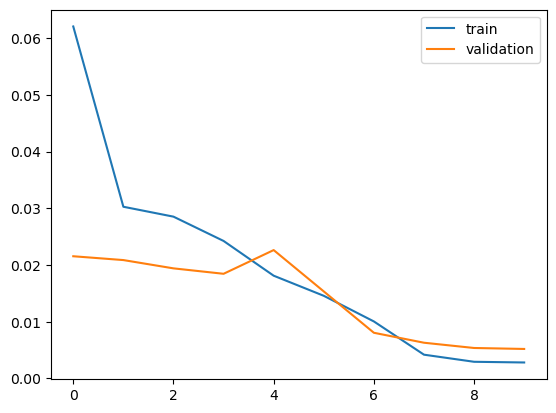

In [ ]:
lstm.run()

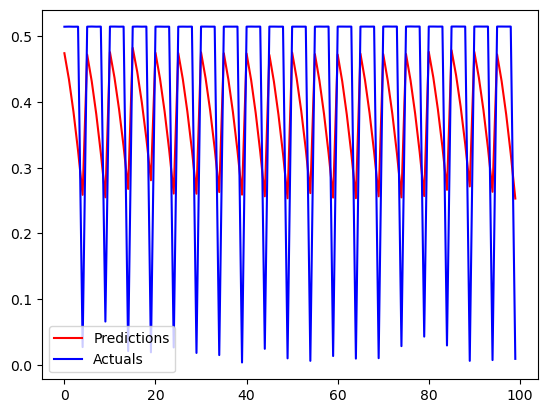

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
preds, mse = lstm.evaluate(plot=True)

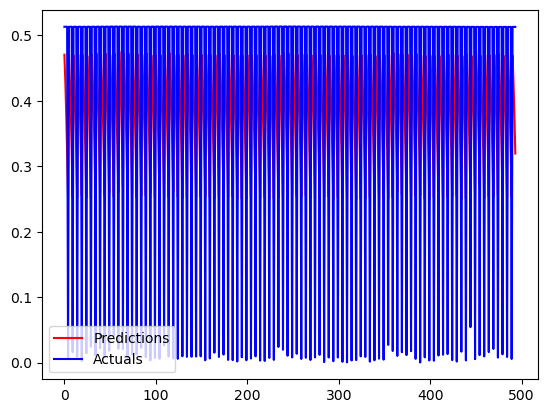

(     Predictions   Actuals
 0       0.470469  0.513161
 1       0.430376  0.513194
 2       0.380548  0.513161
 3       0.321510  0.513161
 4       0.254384  0.005369
 ..           ...       ...
 489     0.254012  0.005631
 490     0.469383  0.512932
 491     0.429038  0.512965
 492     0.378887  0.512899
 493     0.319466  0.512965
 
 [494 rows x 2 columns],
 0.024501275511146486)

In [ ]:
lstm.validate(plot = True, end = 'all')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
       
class cLSTM:
    def __init__(self, data, WINDOW_SIZE = 5, train_size=0.7, test_size=0.2, epochs=10):
        self.data = data
        self.train = None
        self.test = None
        self.val = None
        self.train_scaled = None
        self.test_scaled = None
        self.val_scaled = None
        self.X_train_scaled = None
        self.y_train_scaled = None
        self.X_test_scaled = None
        self.y_test_scaled = None
        self.X_val_scaled = None
        self.y_val_scaled = None
        self.model = None
        self.WINDOW_SIZE = WINDOW_SIZE
        self.train_size = train_size
        self.test_size = test_size
        self.epochs = epochs
        
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(self.WINDOW_SIZE, 1)))
        self.model.add(LSTM(units=50, return_sequences=True))
        self.model.add(LSTM(units=50))
        self.model.add(Dense(1))
        self.model.summary()
        
    # split data into train and test and validation
    def split_data_LSTM(self):
        self.train = self.data[:int(len(self.data)*self.train_size)]
        self.test = self.data[int(len(self.data)*self.train_size):int(len(self.data)*(self.train_size+self.test_size))]
        self.val = self.data[int(len(self.data)*(self.train_size+self.test_size)):]
    
    
    def scale_data(self):
        scaler = MinMaxScaler()
        scaler.fit(self.train.values.reshape(-1, 1))
        self.train_scaled = scaler.transform(self.train.values.reshape(-1, 1))
        self.test_scaled = scaler.transform(self.test.values.reshape(-1, 1))
        self.val_scaled = scaler.transform(self.val.values.reshape(-1, 1))
    
    def create_sequences(self, data):
        xs = []
        ys = []
        for i in range(len(data)-self.WINDOW_SIZE-1):
            x = data[i:(i+self.WINDOW_SIZE)]
            y = data[i+self.WINDOW_SIZE]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
        
    def prepare_data(self):
        self.split_data_LSTM()
        self.scale_data()
        self.X_train_scaled, self.y_train_scaled = self.create_sequences(self.train_scaled)
        self.X_test_scaled, self.y_test_scaled = self.create_sequences(self.test_scaled)
        self.X_val_scaled, self.y_val_scaled = self.create_sequences(self.val_scaled)    
    
    # evaluate model return dataframe and mse
    def evaluate(self, start=0, end=100, plot = False):
        # mse on test data
        predictions = self.model.predict(self.X_test_scaled).flatten()
        df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':self.y_test_scaled.flatten()})
        if(plot):
            plt.plot(df['Predictions'][ start : end ], color='red', label='Predictions')
            plt.plot(df['Actuals'][ start : end], color='blue', label='Actuals')
            # legend
            plt.legend()
            plt.show()
    
    def validate(self, start=0, end=100, plot = False):
        if (end == 'all'): end = len(self.y_val_scaled)
        # predict validation data
        predictions = self.model.predict(self.X_val_scaled).flatten()
        df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':self.y_val_scaled.flatten()})
        # if(plot):
        plt.plot(df['Predictions'], color='red', label='Predictions')
        plt.plot(df['Actuals'], color='blue', label='Actuals')
        # legend
        plt.legend()
        plt.show()
        return df, mse(self.y_val_scaled, predictions)
    
    def train_model(self, best_model = True):
        if(best_model):
        
            cp = ModelCheckpoint('LSTM/', save_best_only=True)
            self.model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
            self.model.fit(self.X_train_scaled, self.y_train_scaled, validation_data=(self.X_val_scaled, self.y_val_scaled), epochs= self.epochs, callbacks=[cp])
        else:
            self.model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
            self.model.fit(self.X_train_scaled, self.y_train_scaled, validation_data=(self.X_val_scaled, self.y_val_scaled), epochs= self.epochs)
        
        # plot loss
        plt.plot(self.model.history.history['loss'], label='train')
        plt.plot(self.model.history.history['val_loss'], label='validation')
        plt.legend()
        plt.show()
    
    def run(self):
        self.prepare_data()
        self.train_model()
        
        
    # predict next value and return unnormalized value
    def predict(self, data):  
        return self.model.predict(data)